In [1]:
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(4)

In [2]:
from __future__ import print_function
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage, MolsToGridImage
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from rdkit import DataStructs
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
import sys
import time
sys.path.append('../../')
from retrosim.utils.draw import ReactionStringToImage, TransformStringToImage
from retrosim.utils.generate_retro_templates import process_an_example
from retrosim.data.get_data import get_data_df, split_data_df
from rdchiral.main import rdchiralRun, rdchiralReaction, rdchiralReactants

from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [3]:
data = get_data_df('../data/data_processed.csv')
split_data_df(data) # 80/10/10 within each class

15151 rows with class value 1
11896 rows with class value 2
5662 rows with class value 3
909 rows with class value 4
672 rows with class value 5
8237 rows with class value 6
4614 rows with class value 7
811 rows with class value 8
1834 rows with class value 9
230 rows with class value 10
train    40008
test      5007
val       5001
Name: dataset, dtype: int64


## Select one set of settings to test

In [4]:
similarity_metric = DataStructs.BulkTanimotoSimilarity # BulkDiceSimilarity or BulkTanimotoSimilarity
similarity_label = 'Tanimoto'
getfp = lambda smi: AllChem.GetMorganFingerprint(Chem.MolFromSmiles(smi), 2, useFeatures=True)
getfp_label = 'Morgan2Feat'

### Only get new FPs if necessary - is a little slow

In [5]:
try:
    if prev_FP != getfp:
        raise NameError
except NameError:
    all_fps = []
    for smi in tqdm(data['prod_smiles']):
        all_fps.append(getfp(smi))
    data['prod_fp'] = all_fps
    prev_FP = getfp

100%|██████████| 50016/50016 [00:43<00:00, 1159.08it/s]


### Get the training data subset of the full data

In [6]:
datasub = data.loc[data['dataset'] == 'train']
fps = list(datasub['prod_fp'])
print(len(fps))

40008


### Define the function for processing

In [7]:
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage, MolToImage
from IPython.display import SVG, display, clear_output
sys.path.append('../../')
from retrosim.utils.generate_retro_templates import process_an_example
from collections import defaultdict

draw = True
debug = False
jx_cache = {}
   
def do_one(prod_smiles, draw=draw, debug=debug):
    global jx_cache
    
    rec_for_printing = ''
    
    ex = Chem.MolFromSmiles(prod_smiles)
    rct = rdchiralReactants(prod_smiles)
    fp = getfp(prod_smiles)
    
    start_time = time.time()
    sims = similarity_metric(fp, [fp_ for fp_ in datasub['prod_fp']])
    print('took {:.3f} seconds to get similarity'.format(time.time() - start_time))
    js = np.argsort(sims)[::-1]

    #temp1 = process_an_example(datasub_val['rxn_smiles'][ix], super_general=True)
    #print('TRUE (val) template:')
    #print(temp1)
    if draw: 
        display(MolToImage(ex))
    
    # Get probability of precursors
    probs = {}
    
    start_time = time.time()
    for j in js[:100]:
        jx = datasub.index[j]
        
        rec_for_printing += '\nPrecedent sim {}, rxn_smiles {}\n'.format(sims[j], datasub['rxn_smiles'][jx])
        if jx in jx_cache:
            (template, rcts_ref_fp) = jx_cache[jx]
        else:
            template = '(' + process_an_example(datasub['rxn_smiles'][jx], super_general=True).replace('>>', ')>>')
            rcts_ref_fp = getfp(datasub['rxn_smiles'][jx].split('>')[0])
            jx_cache[jx] = (template, rcts_ref_fp)
            
        rxn = rdchiralReaction(template)
        try:
            outcomes = rdchiralRun(rxn, rct, combine_enantiomers=False)
        except Exception as e:
            print(e)
            outcomes = []
            
        for precursors in outcomes:
            precursors_fp = getfp(precursors)
            precursors_sim = similarity_metric(precursors_fp, [rcts_ref_fp])[0]
            if draw:
                rec_for_printing += 'prec sim {} smiles {}\n'.format(precursors_sim, precursors)
            if precursors in probs:
                probs[precursors] = max(probs[precursors], precursors_sim * sims[j])
            else:
                probs[precursors] = precursors_sim * sims[j]
    print('took {:.3f} seconds to apply <= 100 templates'.format(time.time() - start_time))

        
    testlimit = 50
    mols = []
    legends = []

    found_rank = 9999
    for r, (prec, prob) in enumerate(sorted(probs.iteritems(), key=lambda x:x[1], reverse=True)[:testlimit]):
        mols.append(Chem.MolFromSmiles(prec))
        legends.append('overall score: {:.3f}'.format(prob))

    if draw: 
        img=MolsToGridImage(mols[:9],molsPerRow=3,subImgSize=(300,300),legends=legends[:9])
        display(img)
        for mol in mols[:9]:
            print(Chem.MolToSmiles(mol, True))
    if debug:
        print(rec_for_printing)
        
    return [Chem.MolToSmiles(x, True) for x in mols]

## Enter SMILES string of molecule to test, call do_one

took 0.081 seconds to get similarity


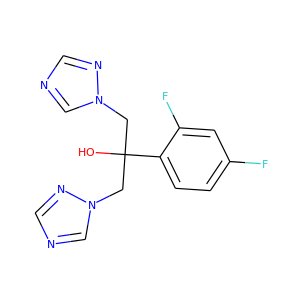

took 0.276 seconds to apply <= 100 templates


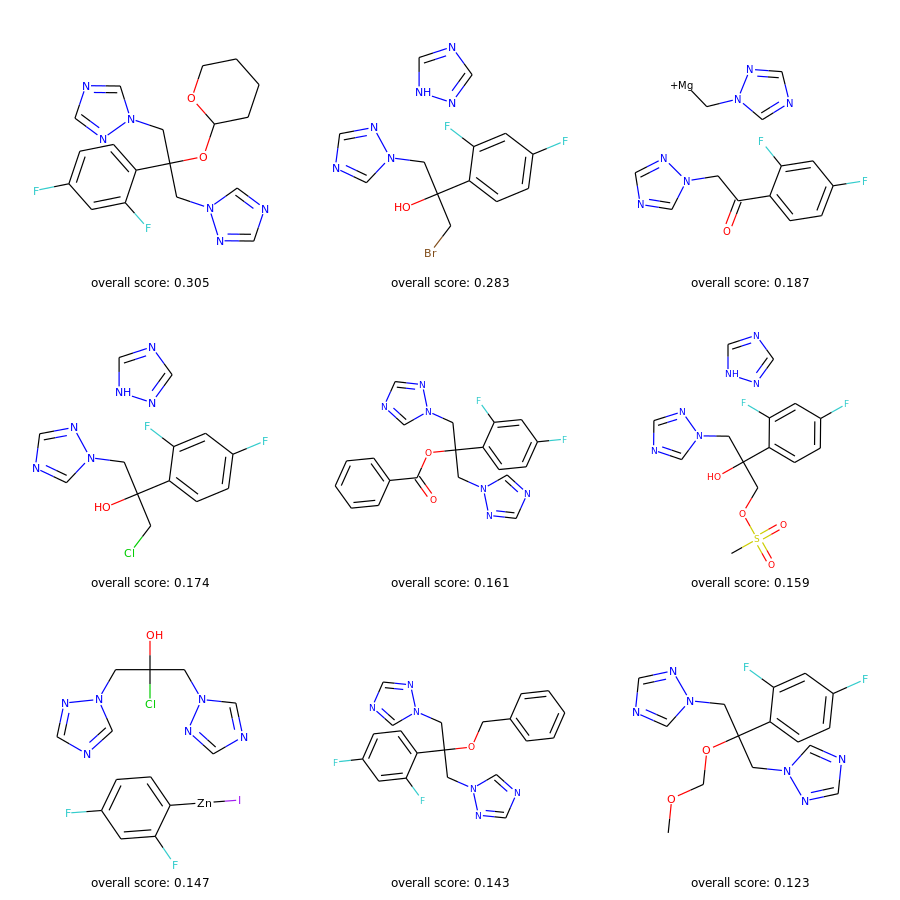

Fc1ccc(C(Cn2cncn2)(Cn2cncn2)OC2CCCCO2)c(F)c1
OC(CBr)(Cn1cncn1)c1ccc(F)cc1F.c1nc[nH]n1
O=C(Cn1cncn1)c1ccc(F)cc1F.[Mg+]Cn1cncn1
OC(CCl)(Cn1cncn1)c1ccc(F)cc1F.c1nc[nH]n1
O=C(OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F)c1ccccc1
CS(=O)(=O)OCC(O)(Cn1cncn1)c1ccc(F)cc1F.c1nc[nH]n1
Fc1ccc([Zn]I)c(F)c1.OC(Cl)(Cn1cncn1)Cn1cncn1
Fc1ccc(C(Cn2cncn2)(Cn2cncn2)OCc2ccccc2)c(F)c1
COCOC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F


In [15]:
do_one('OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F');

took 0.081 seconds to get similarity


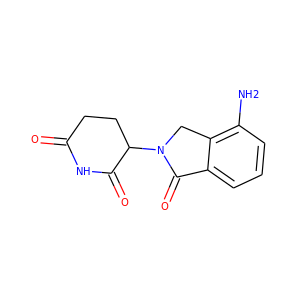

took 0.559 seconds to apply <= 100 templates


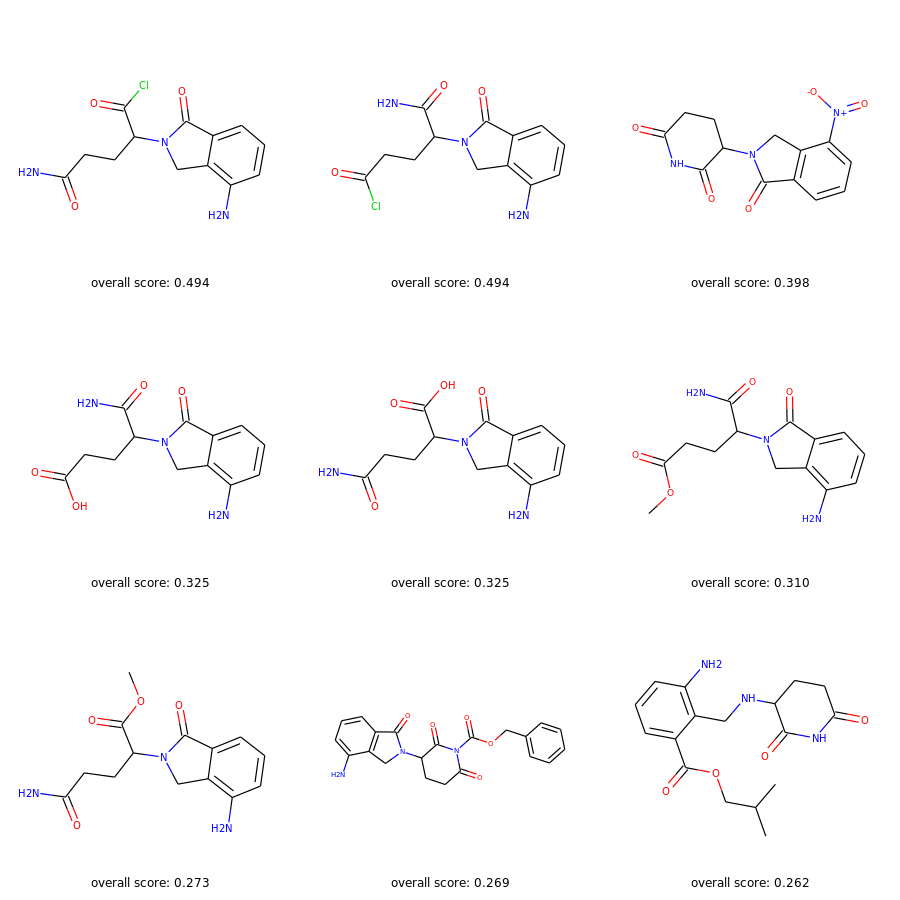

NC(=O)CCC(C(=O)Cl)N1Cc2c(N)cccc2C1=O
NC(=O)C(CCC(=O)Cl)N1Cc2c(N)cccc2C1=O
O=C1CCC(N2Cc3c(cccc3[N+](=O)[O-])C2=O)C(=O)N1
NC(=O)C(CCC(=O)O)N1Cc2c(N)cccc2C1=O
NC(=O)CCC(C(=O)O)N1Cc2c(N)cccc2C1=O
COC(=O)CCC(C(N)=O)N1Cc2c(N)cccc2C1=O
COC(=O)C(CCC(N)=O)N1Cc2c(N)cccc2C1=O
Nc1cccc2c1CN(C1CCC(=O)N(C(=O)OCc3ccccc3)C1=O)C2=O
CC(C)COC(=O)c1cccc(N)c1CNC1CCC(=O)NC1=O

Precedent sim 0.758064516129, rxn_smiles [N:2]#[C:3][c:4]1[cH:5][cH:6][c:7]2[c:8]([cH:9]1)[CH2:10][N:11]([CH:12]1[CH2:13][CH2:14][C:15](=[O:16])[NH:17][C:18]1=[O:19])[C:20]2=[O:21]>>[NH2:2][CH2:3][c:4]1[cH:5][cH:6][c:7]2[c:8]([cH:9]1)[CH2:10][N:11]([CH:12]1[CH2:13][CH2:14][C:15](=[O:16])[NH:17][C:18]1=[O:19])[C:20]2=[O:21]

Precedent sim 0.671428571429, rxn_smiles Cl[C:1](=[O:2])[CH2:3][Cl:4].[NH2:5][c:6]1[cH:7][cH:8][cH:9][c:10]2[c:11]1[CH2:12][N:13]([CH:14]1[CH2:15][CH2:16][C:17](=[O:18])[NH:19][C:20]1=[O:21])[C:22]2=[O:23]>>[C:1](=[O:2])([CH2:3][Cl:4])[NH:5][c:6]1[cH:7][cH:8][cH:9][c:10]2[c:11]1[CH2:12][N:13]([CH:14]1[CH2:15][CH2:16

In [35]:
do_one('O=C1NC(=O)CCC1N3C(=O)c2cccc(c2C3)N', debug=True);

took 0.094 seconds to get similarity


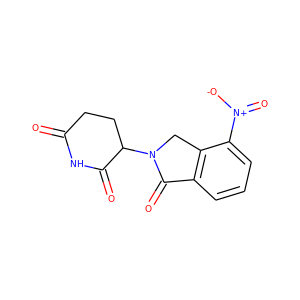

took 1.324 seconds to apply <= 100 templates


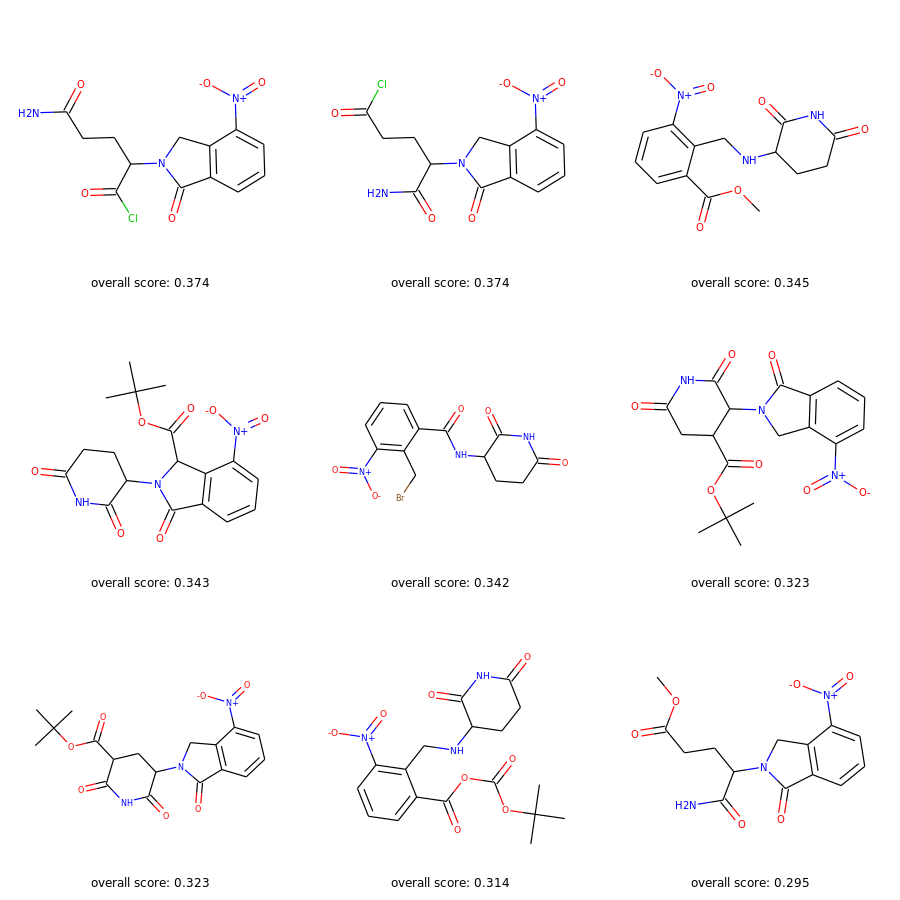

NC(=O)CCC(C(=O)Cl)N1Cc2c(cccc2[N+](=O)[O-])C1=O
NC(=O)C(CCC(=O)Cl)N1Cc2c(cccc2[N+](=O)[O-])C1=O
COC(=O)c1cccc([N+](=O)[O-])c1CNC1CCC(=O)NC1=O
CC(C)(C)OC(=O)C1c2c(cccc2[N+](=O)[O-])C(=O)N1C1CCC(=O)NC1=O
O=C1CCC(NC(=O)c2cccc([N+](=O)[O-])c2CBr)C(=O)N1
CC(C)(C)OC(=O)C1CC(=O)NC(=O)C1N1Cc2c(cccc2[N+](=O)[O-])C1=O
CC(C)(C)OC(=O)C1CC(N2Cc3c(cccc3[N+](=O)[O-])C2=O)C(=O)NC1=O
CC(C)(C)OC(=O)OC(=O)c1cccc([N+](=O)[O-])c1CNC1CCC(=O)NC1=O
COC(=O)CCC(C(N)=O)N1Cc2c(cccc2[N+](=O)[O-])C1=O


In [19]:
do_one('O=C1CCC(N2Cc3c(cccc3[N+](=O)[O-])C2=O)C(=O)N1');

took 0.085 seconds to get similarity


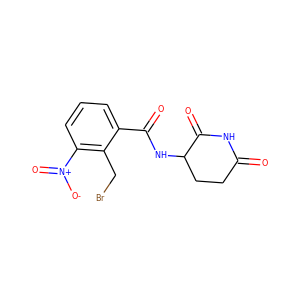

took 1.222 seconds to apply <= 100 templates


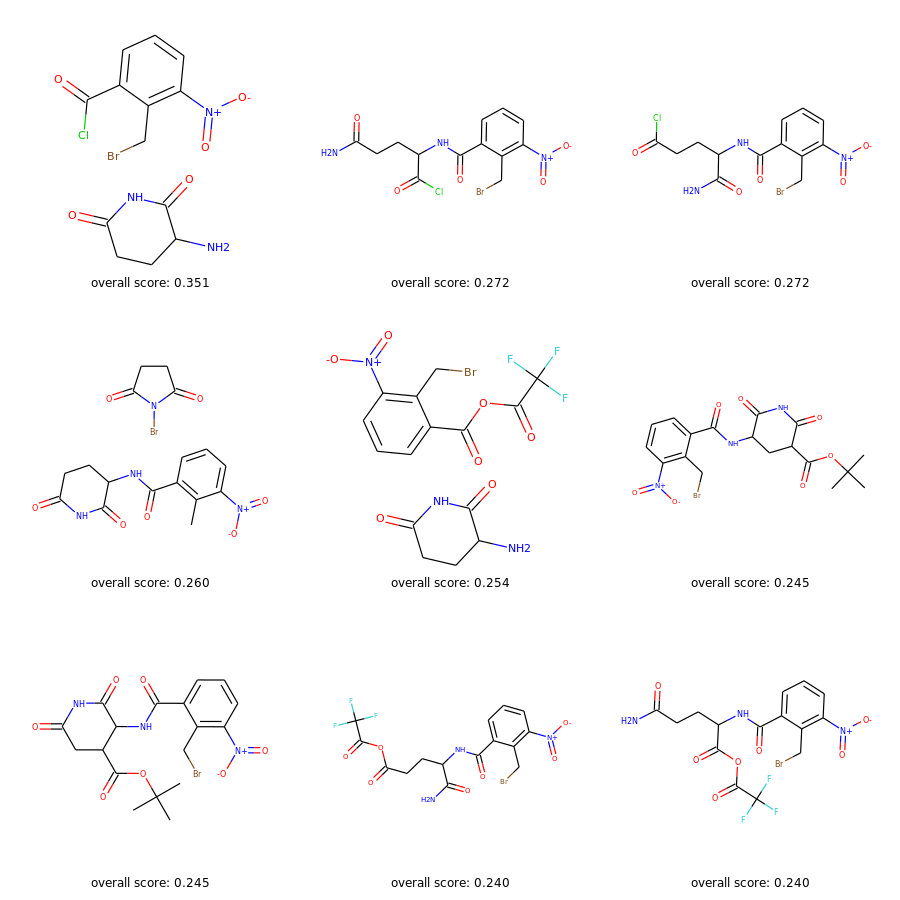

NC1CCC(=O)NC1=O.O=C(Cl)c1cccc([N+](=O)[O-])c1CBr
NC(=O)CCC(NC(=O)c1cccc([N+](=O)[O-])c1CBr)C(=O)Cl
NC(=O)C(CCC(=O)Cl)NC(=O)c1cccc([N+](=O)[O-])c1CBr
Cc1c(C(=O)NC2CCC(=O)NC2=O)cccc1[N+](=O)[O-].O=C1CCC(=O)N1Br
NC1CCC(=O)NC1=O.O=C(OC(=O)C(F)(F)F)c1cccc([N+](=O)[O-])c1CBr
CC(C)(C)OC(=O)C1CC(NC(=O)c2cccc([N+](=O)[O-])c2CBr)C(=O)NC1=O
CC(C)(C)OC(=O)C1CC(=O)NC(=O)C1NC(=O)c1cccc([N+](=O)[O-])c1CBr
NC(=O)C(CCC(=O)OC(=O)C(F)(F)F)NC(=O)c1cccc([N+](=O)[O-])c1CBr
NC(=O)CCC(NC(=O)c1cccc([N+](=O)[O-])c1CBr)C(=O)OC(=O)C(F)(F)F


In [20]:
do_one('O=C1CCC(NC(=O)c2cccc([N+](=O)[O-])c2CBr)C(=O)N1');

took 0.092 seconds to get similarity


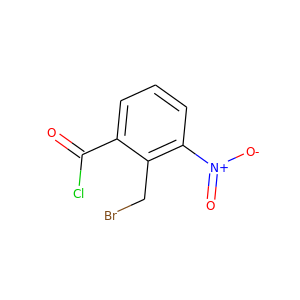

took 1.112 seconds to apply <= 100 templates


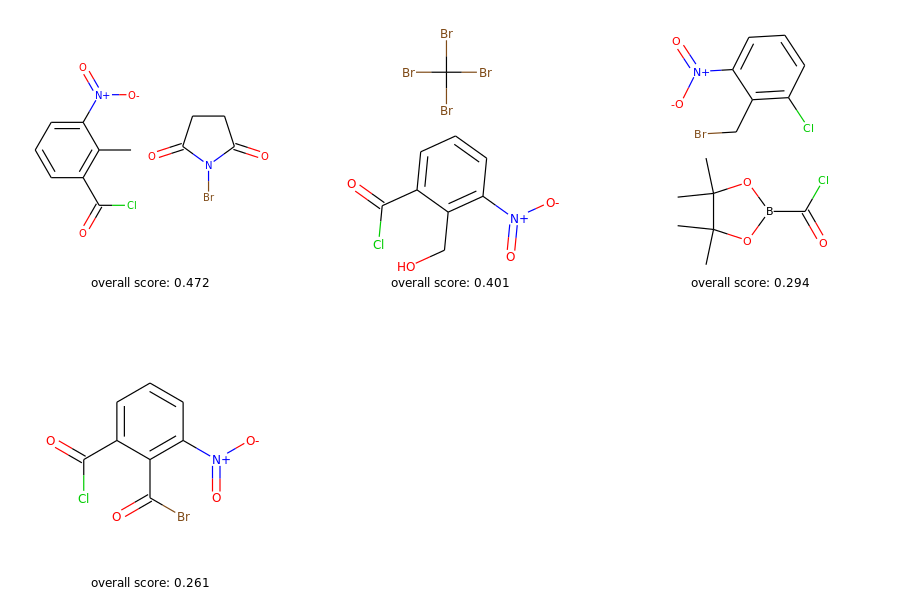

Cc1c(C(=O)Cl)cccc1[N+](=O)[O-].O=C1CCC(=O)N1Br
BrC(Br)(Br)Br.O=C(Cl)c1cccc([N+](=O)[O-])c1CO
CC1(C)OB(C(=O)Cl)OC1(C)C.O=[N+]([O-])c1cccc(Cl)c1CBr
O=C(Cl)c1cccc([N+](=O)[O-])c1C(=O)Br


In [21]:
do_one('O=C(Cl)c1cccc([N+](=O)[O-])c1CBr');

took 0.083 seconds to get similarity


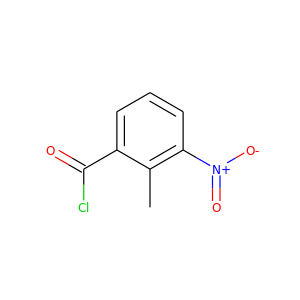

took 0.302 seconds to apply <= 100 templates


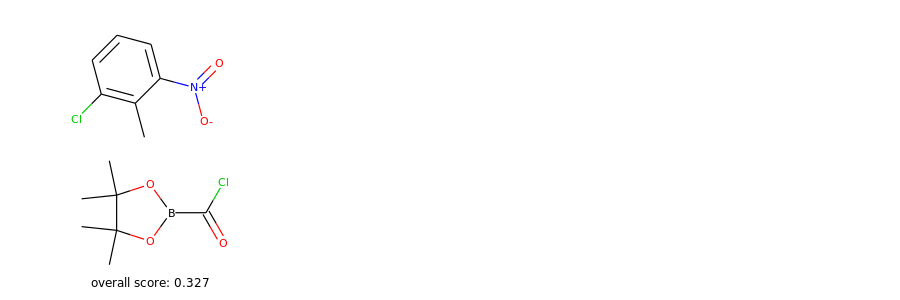

CC1(C)OB(C(=O)Cl)OC1(C)C.Cc1c(Cl)cccc1[N+](=O)[O-]


In [34]:
do_one('O=C(Cl)c1cccc([N+](=O)[O-])c1C');

took 0.092 seconds to get similarity


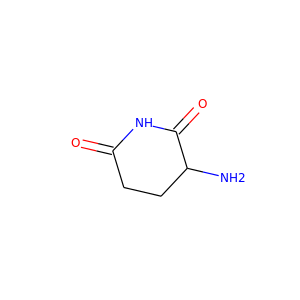

took 1.226 seconds to apply <= 100 templates


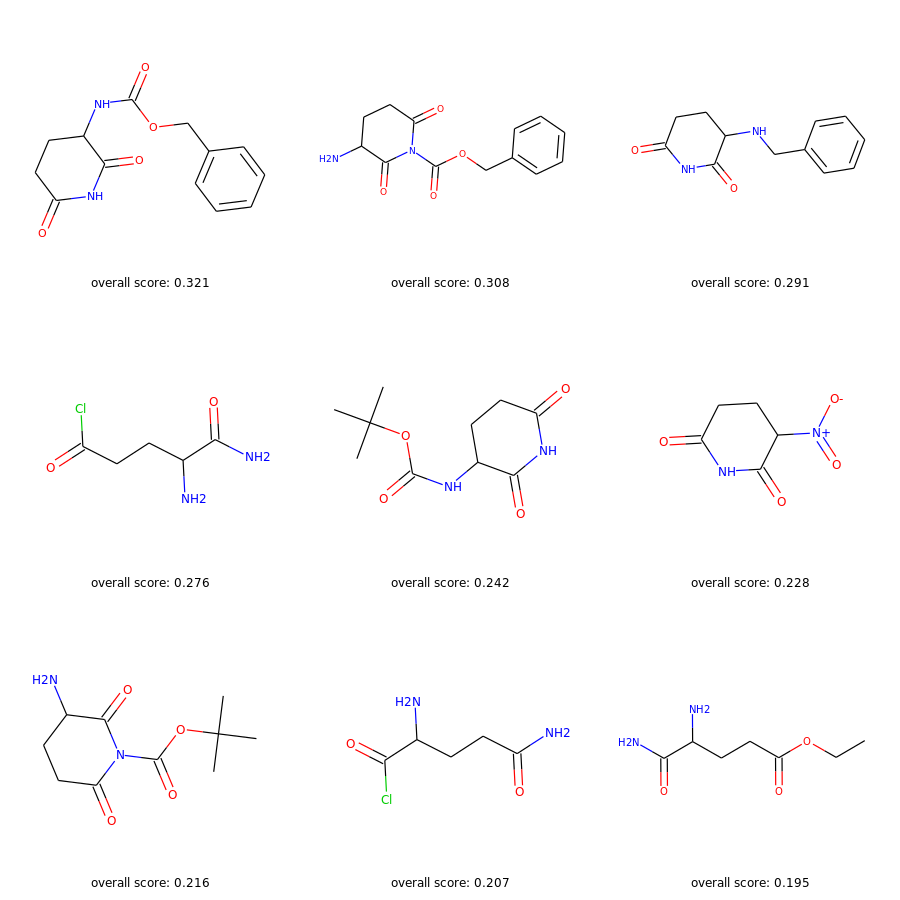

O=C1CCC(NC(=O)OCc2ccccc2)C(=O)N1
NC1CCC(=O)N(C(=O)OCc2ccccc2)C1=O
O=C1CCC(NCc2ccccc2)C(=O)N1
NC(=O)C(N)CCC(=O)Cl
CC(C)(C)OC(=O)NC1CCC(=O)NC1=O
O=C1CCC([N+](=O)[O-])C(=O)N1
CC(C)(C)OC(=O)N1C(=O)CCC(N)C1=O
NC(=O)CCC(N)C(=O)Cl
CCOC(=O)CCC(N)C(N)=O


In [22]:
do_one('NC1CCC(=O)NC1=O');

took 0.080 seconds to get similarity


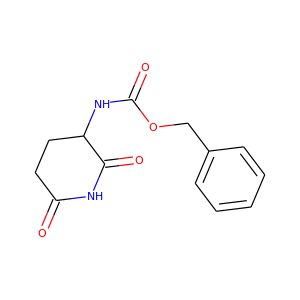

took 1.912 seconds to apply <= 100 templates


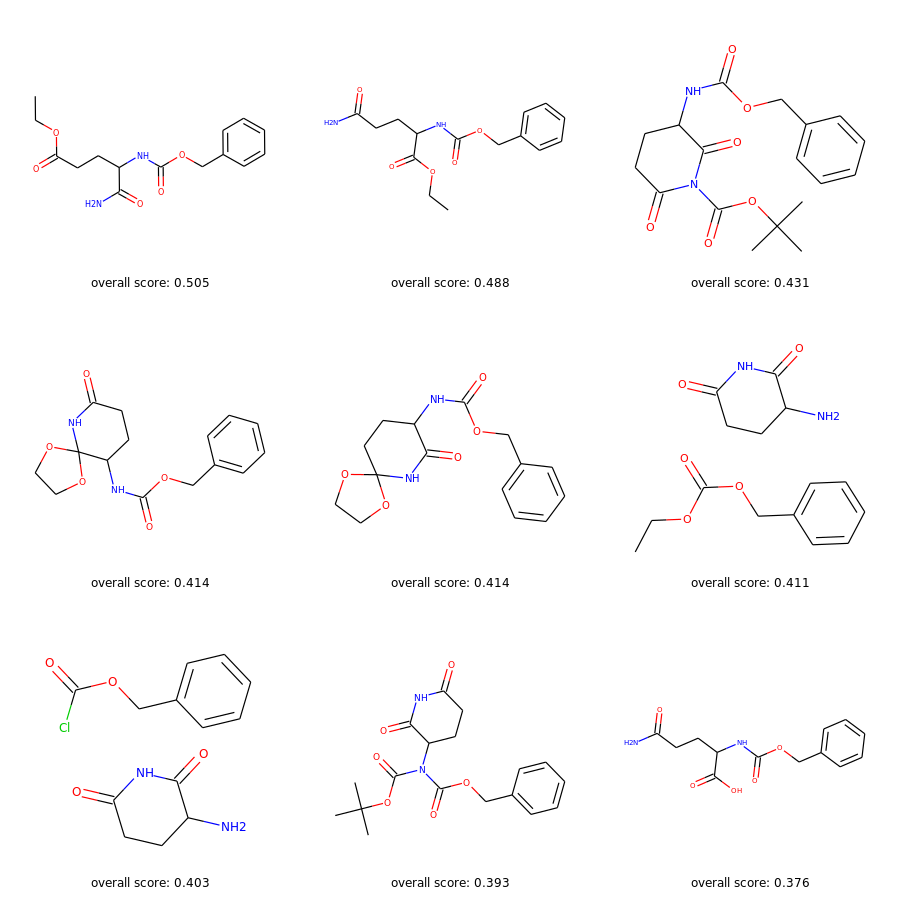

CCOC(=O)CCC(NC(=O)OCc1ccccc1)C(N)=O
CCOC(=O)C(CCC(N)=O)NC(=O)OCc1ccccc1
CC(C)(C)OC(=O)N1C(=O)CCC(NC(=O)OCc2ccccc2)C1=O
O=C1CCC(NC(=O)OCc2ccccc2)C2(N1)OCCO2
O=C(NC1CCC2(NC1=O)OCCO2)OCc1ccccc1
CCOC(=O)OCc1ccccc1.NC1CCC(=O)NC1=O
NC1CCC(=O)NC1=O.O=C(Cl)OCc1ccccc1
CC(C)(C)OC(=O)N(C(=O)OCc1ccccc1)C1CCC(=O)NC1=O
NC(=O)CCC(NC(=O)OCc1ccccc1)C(=O)O


In [23]:
do_one('O=C1CCC(NC(=O)OCc2ccccc2)C(=O)N1');

## Salmeterol

took 0.112 seconds to get similarity


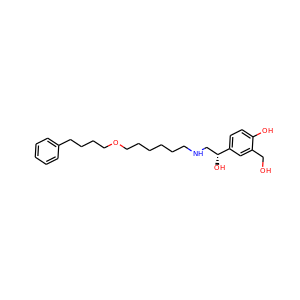

took 2.827 seconds to apply <= 100 templates


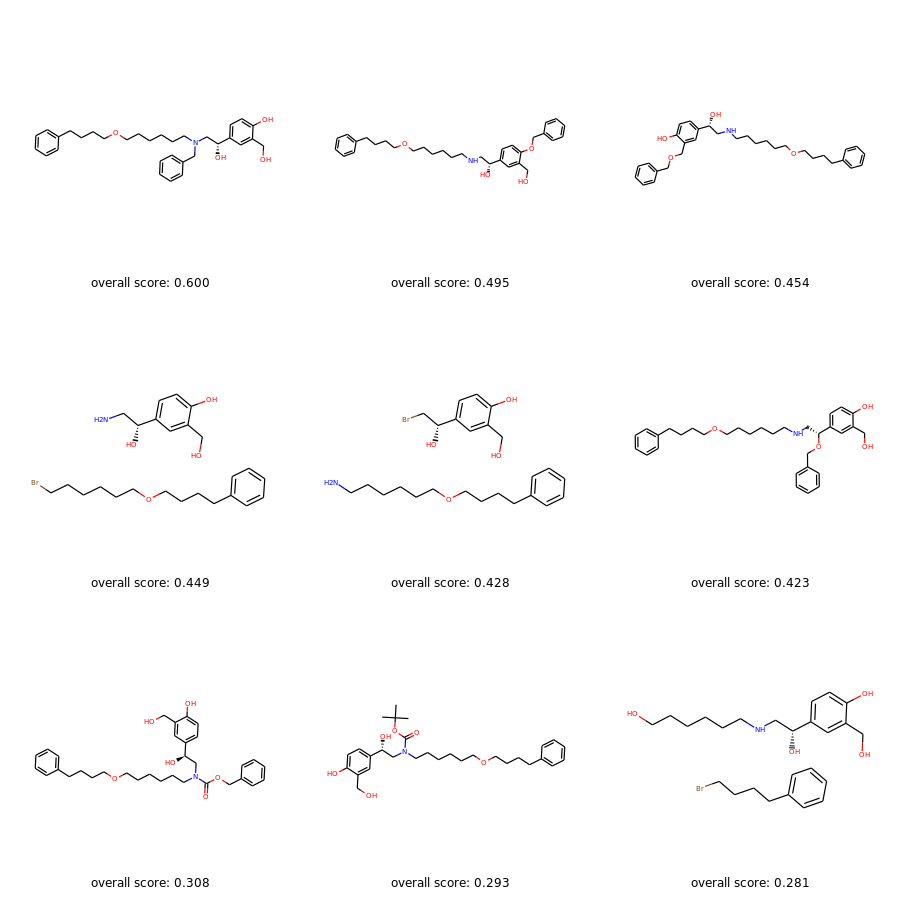

OCc1cc([C@H](O)CN(CCCCCCOCCCCc2ccccc2)Cc2ccccc2)ccc1O
OCc1cc([C@H](O)CNCCCCCCOCCCCc2ccccc2)ccc1OCc1ccccc1
Oc1ccc([C@H](O)CNCCCCCCOCCCCc2ccccc2)cc1COCc1ccccc1
BrCCCCCCOCCCCc1ccccc1.NC[C@@H](O)c1ccc(O)c(CO)c1
NCCCCCCOCCCCc1ccccc1.OCc1cc([C@H](O)CBr)ccc1O
OCc1cc([C@@H](CNCCCCCCOCCCCc2ccccc2)OCc2ccccc2)ccc1O
O=C(OCc1ccccc1)N(CCCCCCOCCCCc1ccccc1)C[C@@H](O)c1ccc(O)c(CO)c1
CC(C)(C)OC(=O)N(CCCCCCOCCCCc1ccccc1)C[C@@H](O)c1ccc(O)c(CO)c1
BrCCCCc1ccccc1.OCCCCCCNC[C@@H](O)c1ccc(O)c(CO)c1


In [24]:
do_one('OCc1cc(ccc1O)[C@H](O)CNCCCCCCOCCCCc2ccccc2');

took 0.103 seconds to get similarity


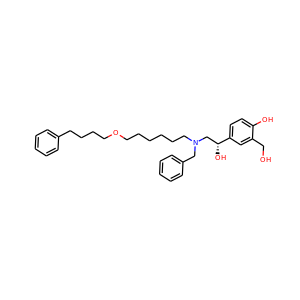

took 2.970 seconds to apply <= 100 templates


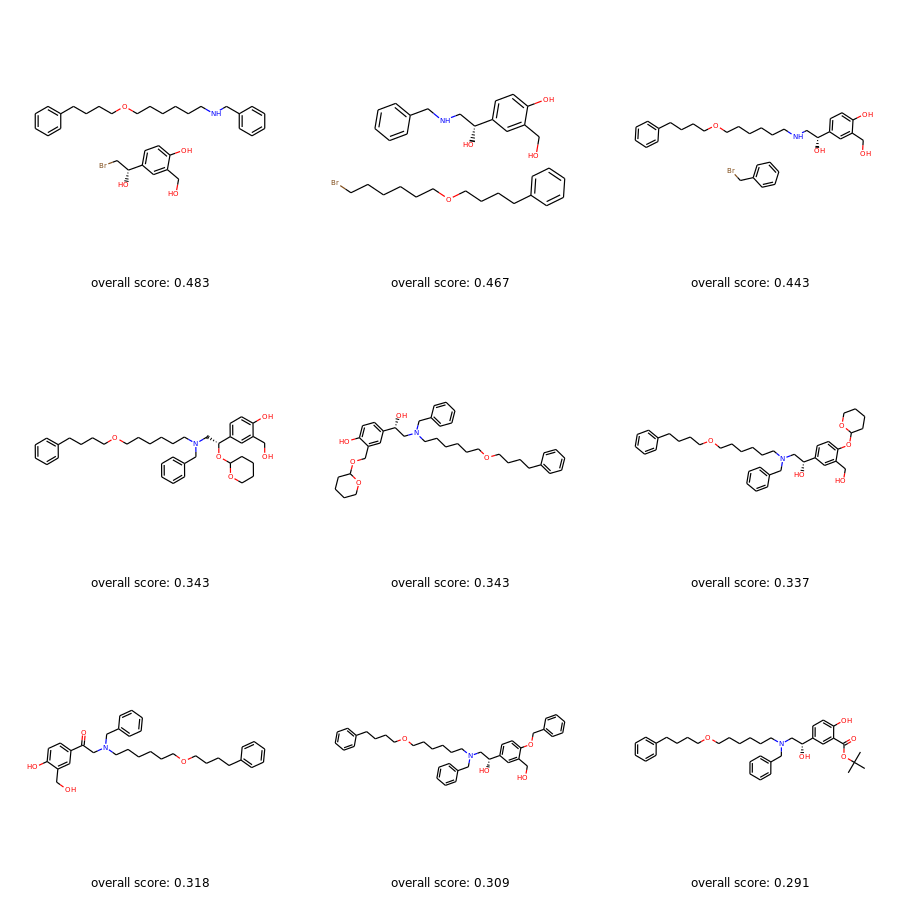

OCc1cc([C@H](O)CBr)ccc1O.c1ccc(CCCCOCCCCCCNCc2ccccc2)cc1
BrCCCCCCOCCCCc1ccccc1.OCc1cc([C@H](O)CNCc2ccccc2)ccc1O
BrCc1ccccc1.OCc1cc([C@H](O)CNCCCCCCOCCCCc2ccccc2)ccc1O
OCc1cc([C@@H](CN(CCCCCCOCCCCc2ccccc2)Cc2ccccc2)OC2CCCCO2)ccc1O
Oc1ccc([C@H](O)CN(CCCCCCOCCCCc2ccccc2)Cc2ccccc2)cc1COC1CCCCO1
OCc1cc([C@H](O)CN(CCCCCCOCCCCc2ccccc2)Cc2ccccc2)ccc1OC1CCCCO1
O=C(CN(CCCCCCOCCCCc1ccccc1)Cc1ccccc1)c1ccc(O)c(CO)c1
OCc1cc([C@H](O)CN(CCCCCCOCCCCc2ccccc2)Cc2ccccc2)ccc1OCc1ccccc1
CC(C)(C)OC(=O)c1cc([C@H](O)CN(CCCCCCOCCCCc2ccccc2)Cc2ccccc2)ccc1O


In [25]:
do_one('OCc1cc([C@H](O)CN(CCCCCCOCCCCc2ccccc2)Cc2ccccc2)ccc1O');

took 0.092 seconds to get similarity


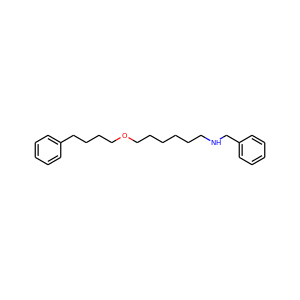

took 0.477 seconds to apply <= 100 templates


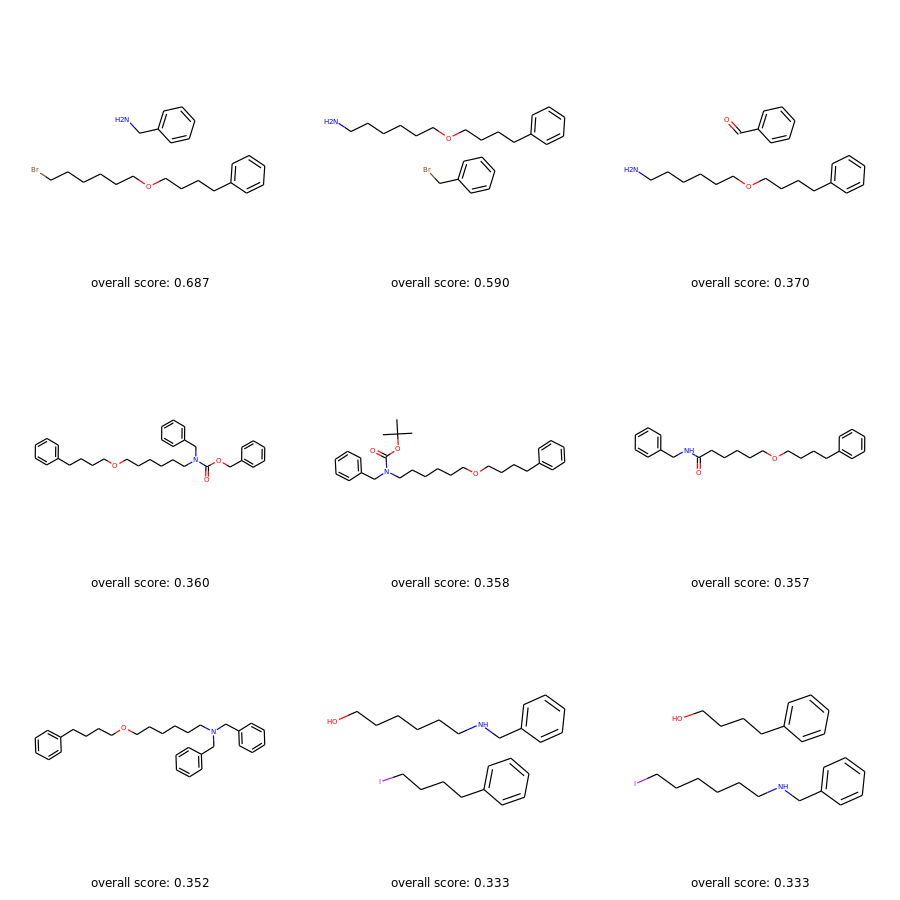

BrCCCCCCOCCCCc1ccccc1.NCc1ccccc1
BrCc1ccccc1.NCCCCCCOCCCCc1ccccc1
NCCCCCCOCCCCc1ccccc1.O=Cc1ccccc1
O=C(OCc1ccccc1)N(CCCCCCOCCCCc1ccccc1)Cc1ccccc1
CC(C)(C)OC(=O)N(CCCCCCOCCCCc1ccccc1)Cc1ccccc1
O=C(CCCCCOCCCCc1ccccc1)NCc1ccccc1
c1ccc(CCCCOCCCCCCN(Cc2ccccc2)Cc2ccccc2)cc1
ICCCCc1ccccc1.OCCCCCCNCc1ccccc1
ICCCCCCNCc1ccccc1.OCCCCc1ccccc1
took 0.075 seconds to get similarity


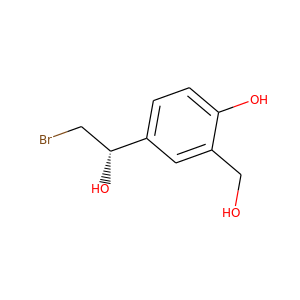

took 1.404 seconds to apply <= 100 templates


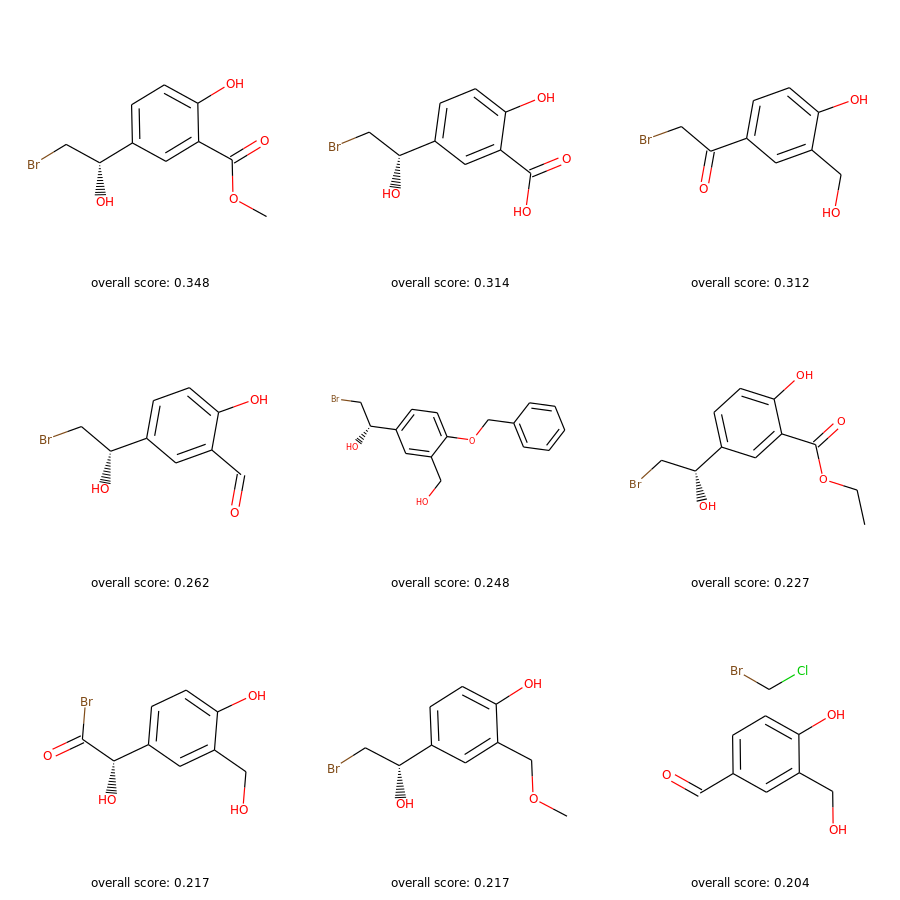

COC(=O)c1cc([C@H](O)CBr)ccc1O
O=C(O)c1cc([C@H](O)CBr)ccc1O
O=C(CBr)c1ccc(O)c(CO)c1
O=Cc1cc([C@H](O)CBr)ccc1O
OCc1cc([C@H](O)CBr)ccc1OCc1ccccc1
CCOC(=O)c1cc([C@H](O)CBr)ccc1O
O=C(Br)[C@@H](O)c1ccc(O)c(CO)c1
COCc1cc([C@H](O)CBr)ccc1O
ClCBr.O=Cc1ccc(O)c(CO)c1


In [27]:
do_one('c1ccc(CCCCOCCCCCCNCc2ccccc2)cc1');
do_one('OCc1cc([C@H](O)CBr)ccc1O');

took 0.077 seconds to get similarity


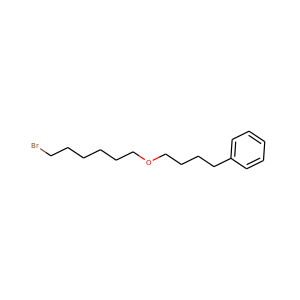

took 0.674 seconds to apply <= 100 templates


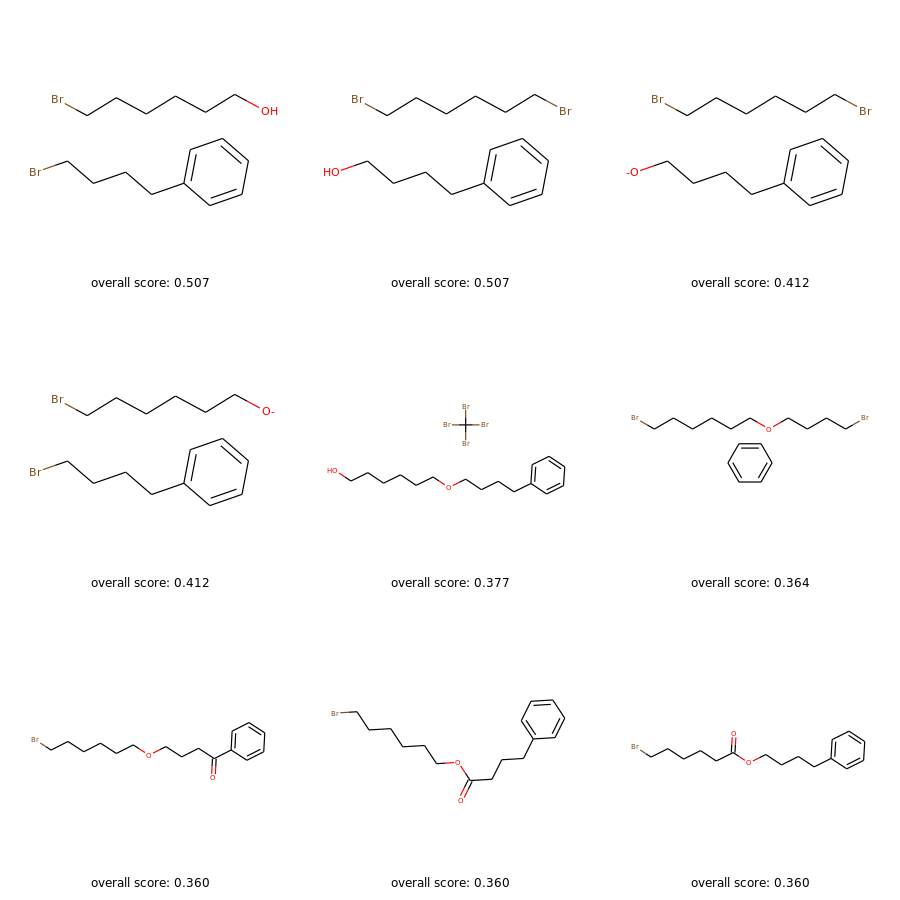

BrCCCCc1ccccc1.OCCCCCCBr
BrCCCCCCBr.OCCCCc1ccccc1
BrCCCCCCBr.[O-]CCCCc1ccccc1
BrCCCCc1ccccc1.[O-]CCCCCCBr
BrC(Br)(Br)Br.OCCCCCCOCCCCc1ccccc1
BrCCCCCCOCCCCBr.c1ccccc1
O=C(CCCOCCCCCCBr)c1ccccc1
O=C(CCCc1ccccc1)OCCCCCCBr
O=C(CCCCCBr)OCCCCc1ccccc1
took 0.077 seconds to get similarity


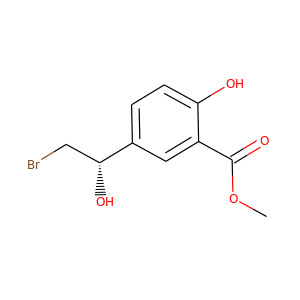

took 0.276 seconds to apply <= 100 templates


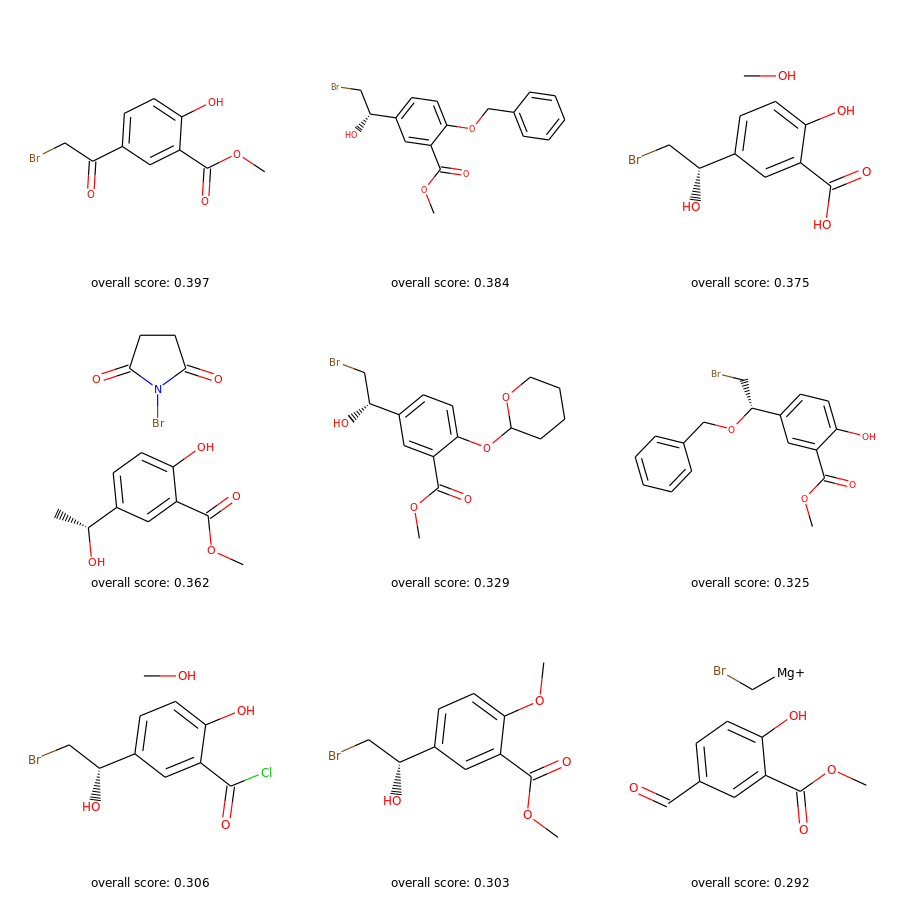

COC(=O)c1cc(C(=O)CBr)ccc1O
COC(=O)c1cc([C@H](O)CBr)ccc1OCc1ccccc1
CO.O=C(O)c1cc([C@H](O)CBr)ccc1O
COC(=O)c1cc([C@@H](C)O)ccc1O.O=C1CCC(=O)N1Br
COC(=O)c1cc([C@H](O)CBr)ccc1OC1CCCCO1
COC(=O)c1cc([C@@H](CBr)OCc2ccccc2)ccc1O
CO.O=C(Cl)c1cc([C@H](O)CBr)ccc1O
COC(=O)c1cc([C@H](O)CBr)ccc1OC
COC(=O)c1cc(C=O)ccc1O.[Mg+]CBr

Precedent sim 0.645833333333, rxn_smiles O[CH3:1].[O:2]=[C:3]([OH:4])[c:5]1[cH:6][cH:7][c:8]([OH:9])[c:10]([C:11]([F:12])([F:13])[F:14])[cH:15]1>>[CH3:1][O:4][C:3](=[O:2])[c:5]1[cH:6][cH:7][c:8]([OH:9])[c:10]([C:11]([F:12])([F:13])[F:14])[cH:15]1
prec sim 0.58 smiles CO.O=C(O)c1cc([C@H](O)CBr)ccc1O

Precedent sim 0.630434782609, rxn_smiles [CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][cH:7][cH:8][c:9]([C:10]([CH3:11])=[O:12])[cH:13]1>>[CH3:1][O:2][C:3](=[O:4])[c:5]1[cH:6][cH:7][cH:8][c:9]([CH:10]([CH3:11])[OH:12])[cH:13]1
prec sim 0.630434782609 smiles COC(=O)c1cc(C(=O)CBr)ccc1O

Precedent sim 0.6, rxn_smiles O[CH3:1].[O:2]=[C:3]([OH:4])[c:5]1[cH:6][c:7]([I:8])[cH:9][cH:10][c:11]1[O

In [36]:
do_one('BrCCCCCCOCCCCc1ccccc1');
do_one('COC(=O)c1cc([C@H](O)CBr)ccc1O', debug=True);

## Sofosbuvir

took 0.095 seconds to get similarity


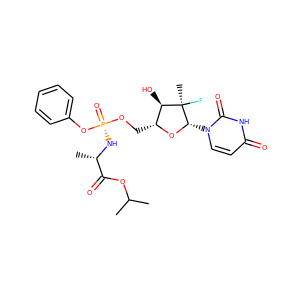

took 0.494 seconds to apply <= 100 templates


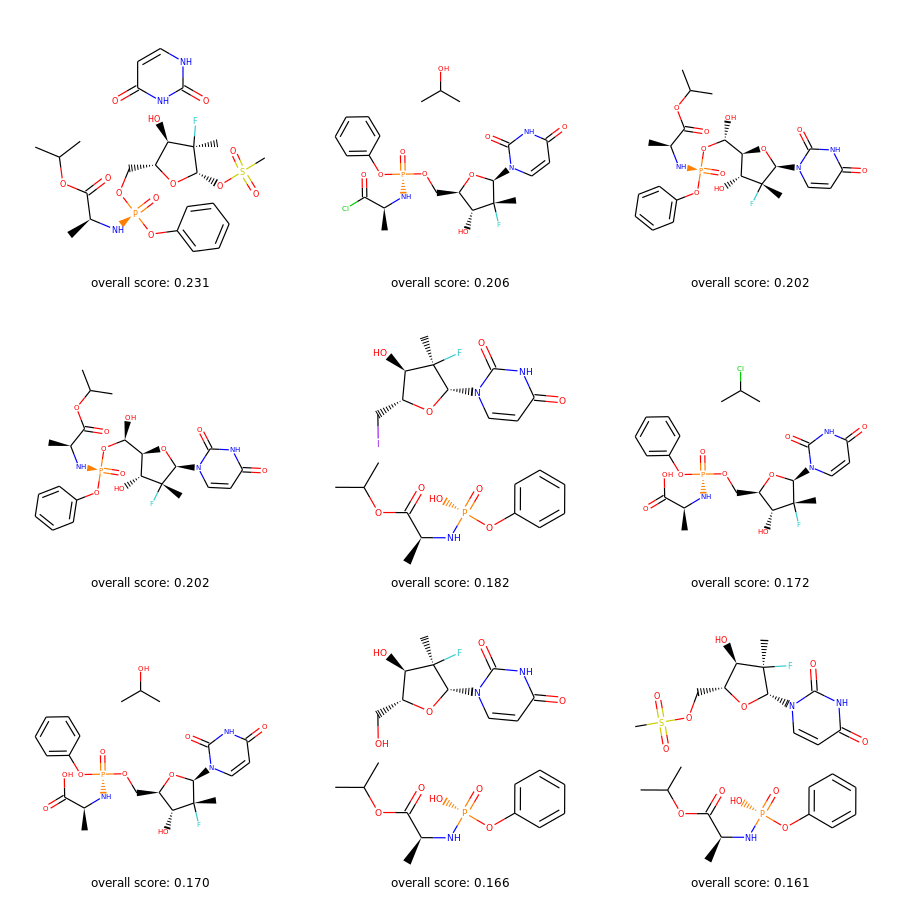

CC(C)OC(=O)[C@H](C)N[P@](=O)(OC[C@H]1O[C@@H](OS(C)(=O)=O)[C@](C)(F)[C@@H]1O)Oc1ccccc1.O=c1cc[nH]c(=O)[nH]1
CC(C)O.C[C@H](N[P@](=O)(OC[C@H]1O[C@@H](n2ccc(=O)[nH]c2=O)[C@](C)(F)[C@@H]1O)Oc1ccccc1)C(=O)Cl
CC(C)OC(=O)[C@H](C)N[P@@](=O)(Oc1ccccc1)O[C@H](O)[C@H]1O[C@@H](n2ccc(=O)[nH]c2=O)[C@](C)(F)[C@@H]1O
CC(C)OC(=O)[C@H](C)N[P@@](=O)(Oc1ccccc1)O[C@@H](O)[C@H]1O[C@@H](n2ccc(=O)[nH]c2=O)[C@](C)(F)[C@@H]1O
CC(C)OC(=O)[C@H](C)N[P@](=O)(O)Oc1ccccc1.C[C@@]1(F)[C@H](O)[C@@H](CI)O[C@H]1n1ccc(=O)[nH]c1=O
CC(C)Cl.C[C@H](N[P@](=O)(OC[C@H]1O[C@@H](n2ccc(=O)[nH]c2=O)[C@](C)(F)[C@@H]1O)Oc1ccccc1)C(=O)O
CC(C)O.C[C@H](N[P@](=O)(OC[C@H]1O[C@@H](n2ccc(=O)[nH]c2=O)[C@](C)(F)[C@@H]1O)Oc1ccccc1)C(=O)O
CC(C)OC(=O)[C@H](C)N[P@](=O)(O)Oc1ccccc1.C[C@@]1(F)[C@H](O)[C@@H](CO)O[C@H]1n1ccc(=O)[nH]c1=O
CC(C)OC(=O)[C@H](C)N[P@](=O)(O)Oc1ccccc1.C[C@@]1(F)[C@H](O)[C@@H](COS(C)(=O)=O)O[C@H]1n1ccc(=O)[nH]c1=O


In [29]:
do_one('C[C@@H](C(OC(C)C)=O)N[P@](OC[C@@H]1[C@H]([C@@](F)([C@@H](O1)N2C=CC(NC2=O)=O)C)O)(OC3=CC=CC=C3)=O');

took 0.095 seconds to get similarity


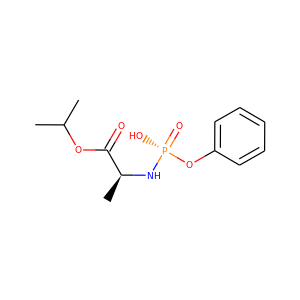

took 1.212 seconds to apply <= 100 templates


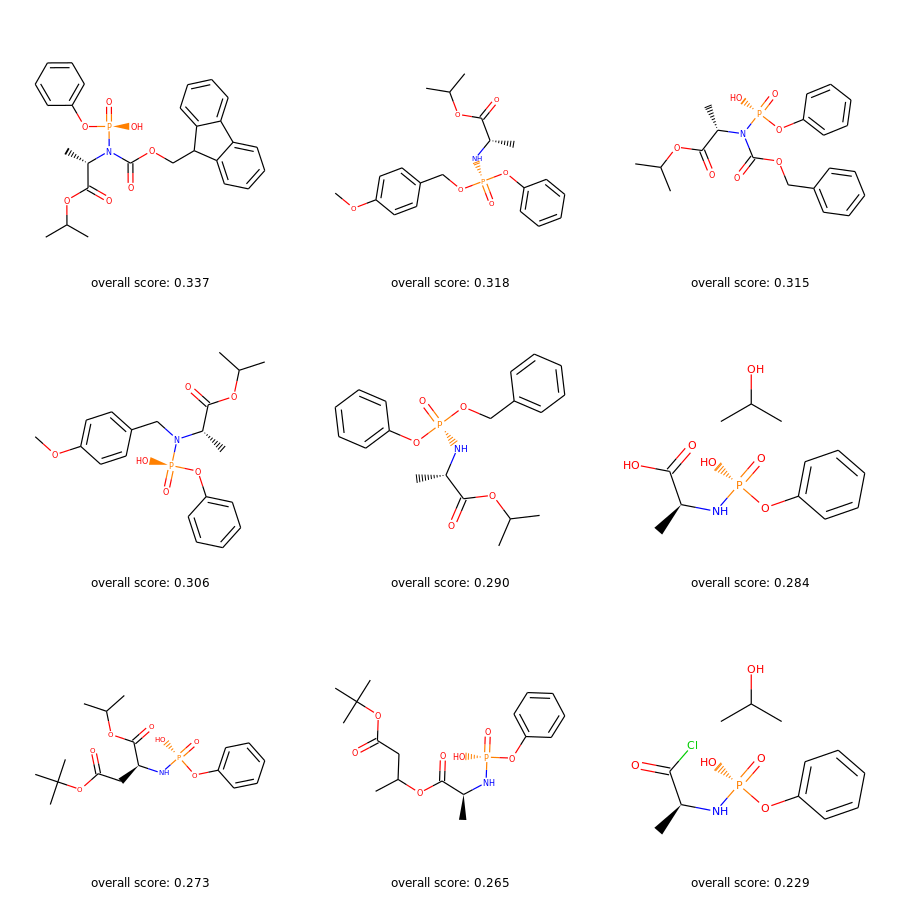

CC(C)OC(=O)[C@H](C)N(C(=O)OCC1c2ccccc2-c2ccccc21)[P@](=O)(O)Oc1ccccc1
COc1ccc(CO[P@@](=O)(N[C@@H](C)C(=O)OC(C)C)Oc2ccccc2)cc1
CC(C)OC(=O)[C@H](C)N(C(=O)OCc1ccccc1)[P@](=O)(O)Oc1ccccc1
COc1ccc(CN([C@@H](C)C(=O)OC(C)C)[P@](=O)(O)Oc2ccccc2)cc1
CC(C)OC(=O)[C@H](C)N[P@](=O)(OCc1ccccc1)Oc1ccccc1
CC(C)O.C[C@H](N[P@](=O)(O)Oc1ccccc1)C(=O)O
CC(C)OC(=O)[C@H](CC(=O)OC(C)(C)C)N[P@](=O)(O)Oc1ccccc1
CC(CC(=O)OC(C)(C)C)OC(=O)[C@H](C)N[P@](=O)(O)Oc1ccccc1
CC(C)O.C[C@H](N[P@](=O)(O)Oc1ccccc1)C(=O)Cl
took 0.065 seconds to get similarity


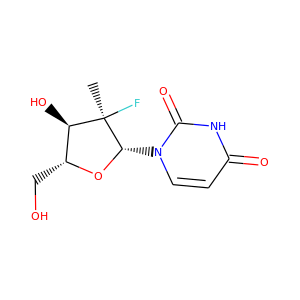

took 1.309 seconds to apply <= 100 templates


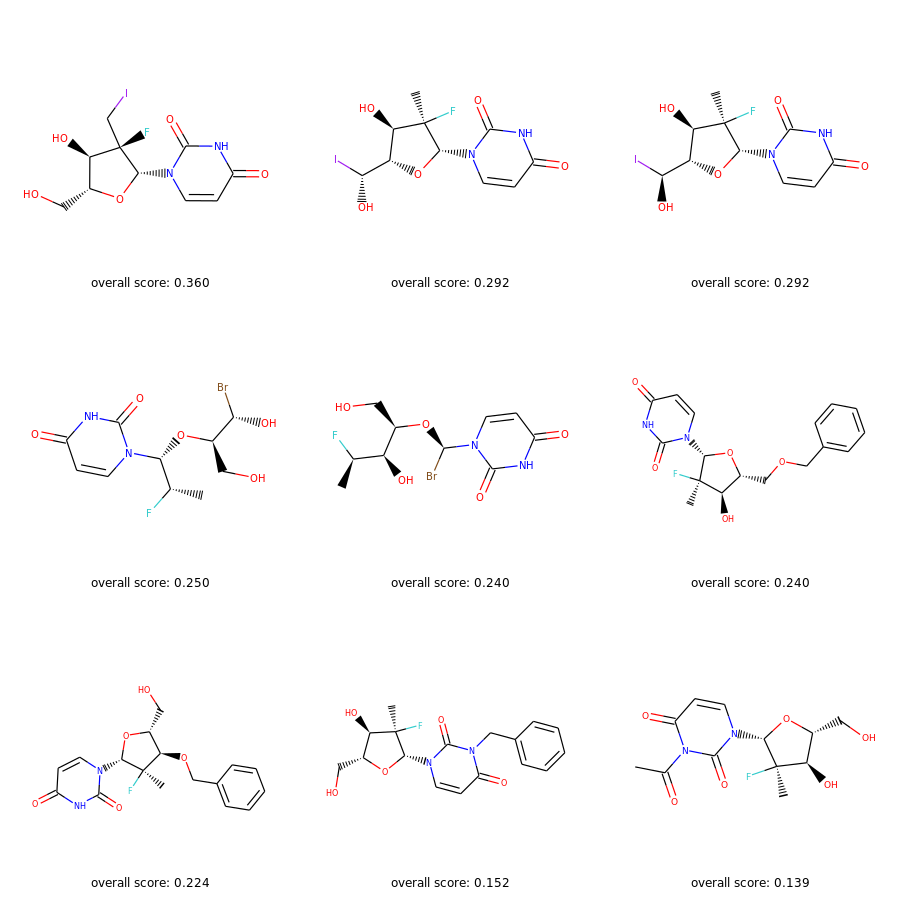

O=c1ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@]2(F)CI)c(=O)[nH]1
C[C@@]1(F)[C@H](O)[C@@H]([C@H](O)I)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](O)[C@@H]([C@@H](O)I)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@H](F)[C@@H](O[C@H](CO)[C@@H](O)Br)n1ccc(=O)[nH]c1=O
C[C@@H](F)[C@H](O)[C@@H](CO)O[C@H](Br)n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](O)[C@@H](COCc2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](OCc2ccccc2)[C@@H](CO)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](O)[C@@H](CO)O[C@H]1n1ccc(=O)n(Cc2ccccc2)c1=O
CC(=O)n1c(=O)ccn([C@@H]2O[C@H](CO)[C@@H](O)[C@@]2(C)F)c1=O


In [30]:
do_one('CC(C)OC(=O)[C@H](C)N[P@](=O)(O)Oc1ccccc1');
do_one('C[C@@]1(F)[C@H](O)[C@@H](CO)O[C@H]1n1ccc(=O)[nH]c1=O');

took 0.092 seconds to get similarity


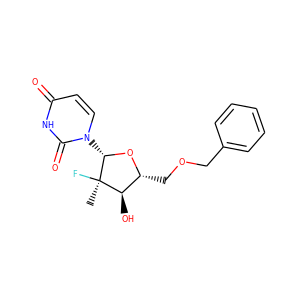

took 1.432 seconds to apply <= 100 templates


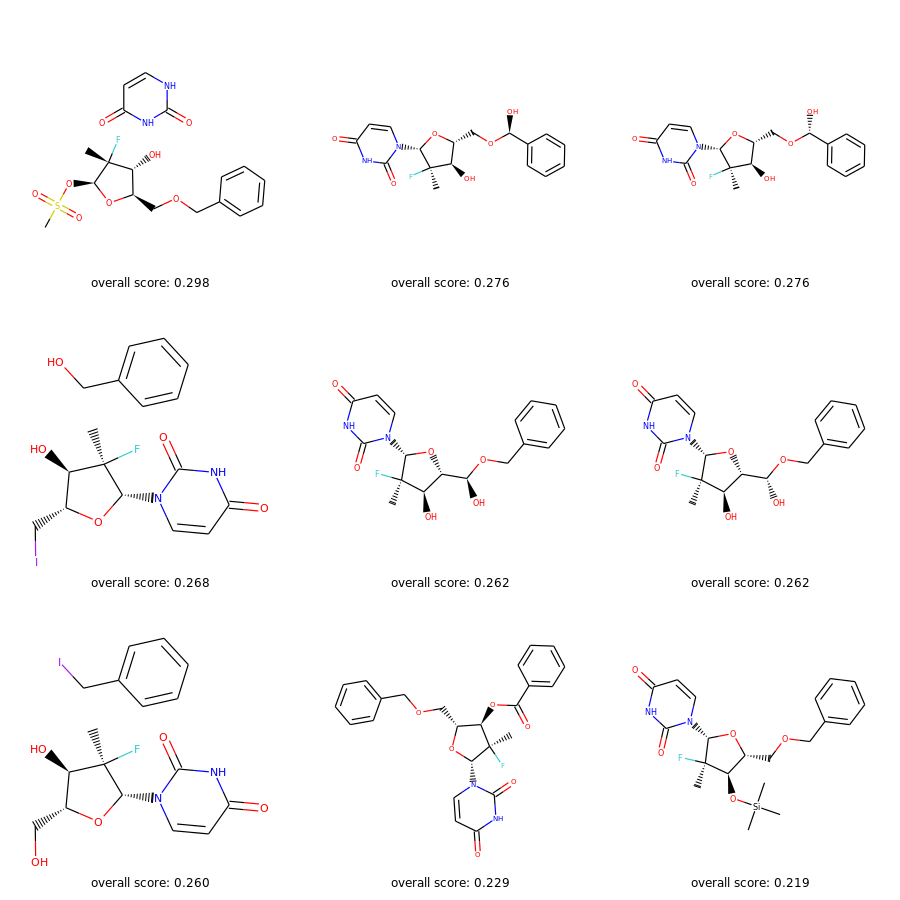

C[C@]1(F)[C@H](OS(C)(=O)=O)O[C@H](COCc2ccccc2)[C@H]1O.O=c1cc[nH]c(=O)[nH]1
C[C@@]1(F)[C@H](O)[C@@H](CO[C@@H](O)c2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](O)[C@@H](CO[C@H](O)c2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](O)[C@@H](CI)O[C@H]1n1ccc(=O)[nH]c1=O.OCc1ccccc1
C[C@@]1(F)[C@H](O)[C@@H]([C@H](O)OCc2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](O)[C@@H]([C@@H](O)OCc2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](O)[C@@H](CO)O[C@H]1n1ccc(=O)[nH]c1=O.ICc1ccccc1
C[C@@]1(F)[C@H](OC(=O)c2ccccc2)[C@@H](COCc2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](O[Si](C)(C)C)[C@@H](COCc2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O


In [31]:
do_one('C[C@@]1(F)[C@H](O)[C@@H](COCc2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O'); # protected

took 0.118 seconds to get similarity


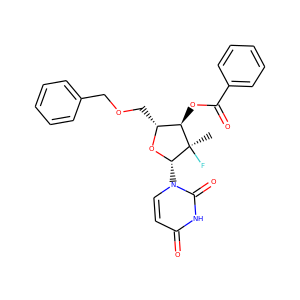

took 1.958 seconds to apply <= 100 templates


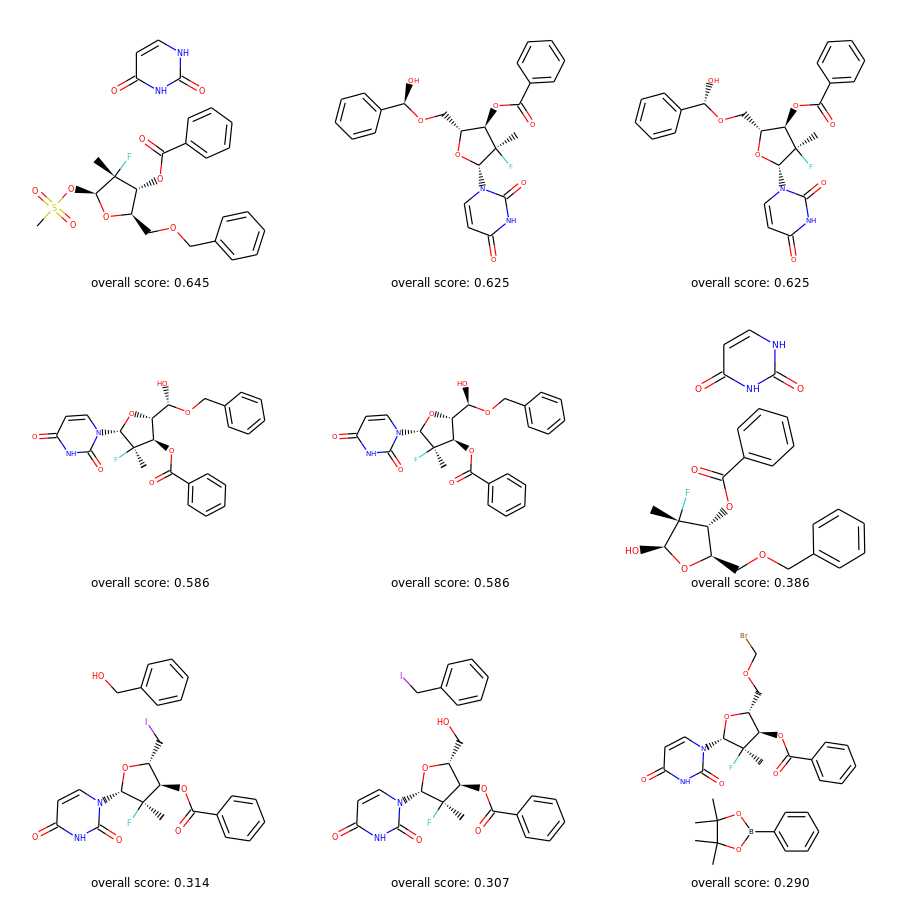

C[C@]1(F)[C@H](OS(C)(=O)=O)O[C@H](COCc2ccccc2)[C@H]1OC(=O)c1ccccc1.O=c1cc[nH]c(=O)[nH]1
C[C@@]1(F)[C@H](OC(=O)c2ccccc2)[C@@H](CO[C@H](O)c2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](OC(=O)c2ccccc2)[C@@H](CO[C@@H](O)c2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](OC(=O)c2ccccc2)[C@@H]([C@H](O)OCc2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@@]1(F)[C@H](OC(=O)c2ccccc2)[C@@H]([C@@H](O)OCc2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O
C[C@]1(F)[C@H](O)O[C@H](COCc2ccccc2)[C@H]1OC(=O)c1ccccc1.O=c1cc[nH]c(=O)[nH]1
C[C@@]1(F)[C@H](OC(=O)c2ccccc2)[C@@H](CI)O[C@H]1n1ccc(=O)[nH]c1=O.OCc1ccccc1
C[C@@]1(F)[C@H](OC(=O)c2ccccc2)[C@@H](CO)O[C@H]1n1ccc(=O)[nH]c1=O.ICc1ccccc1
CC1(C)OB(c2ccccc2)OC1(C)C.C[C@@]1(F)[C@H](OC(=O)c2ccccc2)[C@@H](COCBr)O[C@H]1n1ccc(=O)[nH]c1=O


In [32]:
do_one('C[C@@]1(F)[C@H](OC(=O)c2ccccc2)[C@@H](COCc2ccccc2)O[C@H]1n1ccc(=O)[nH]c1=O'); # protect again

## Similarity maps

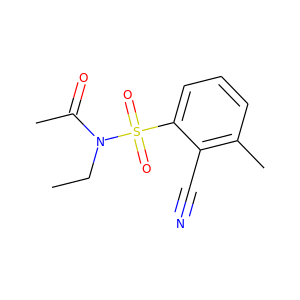

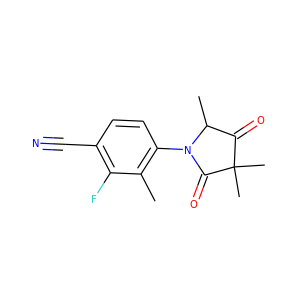

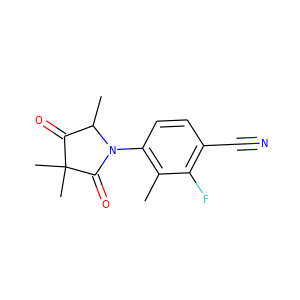

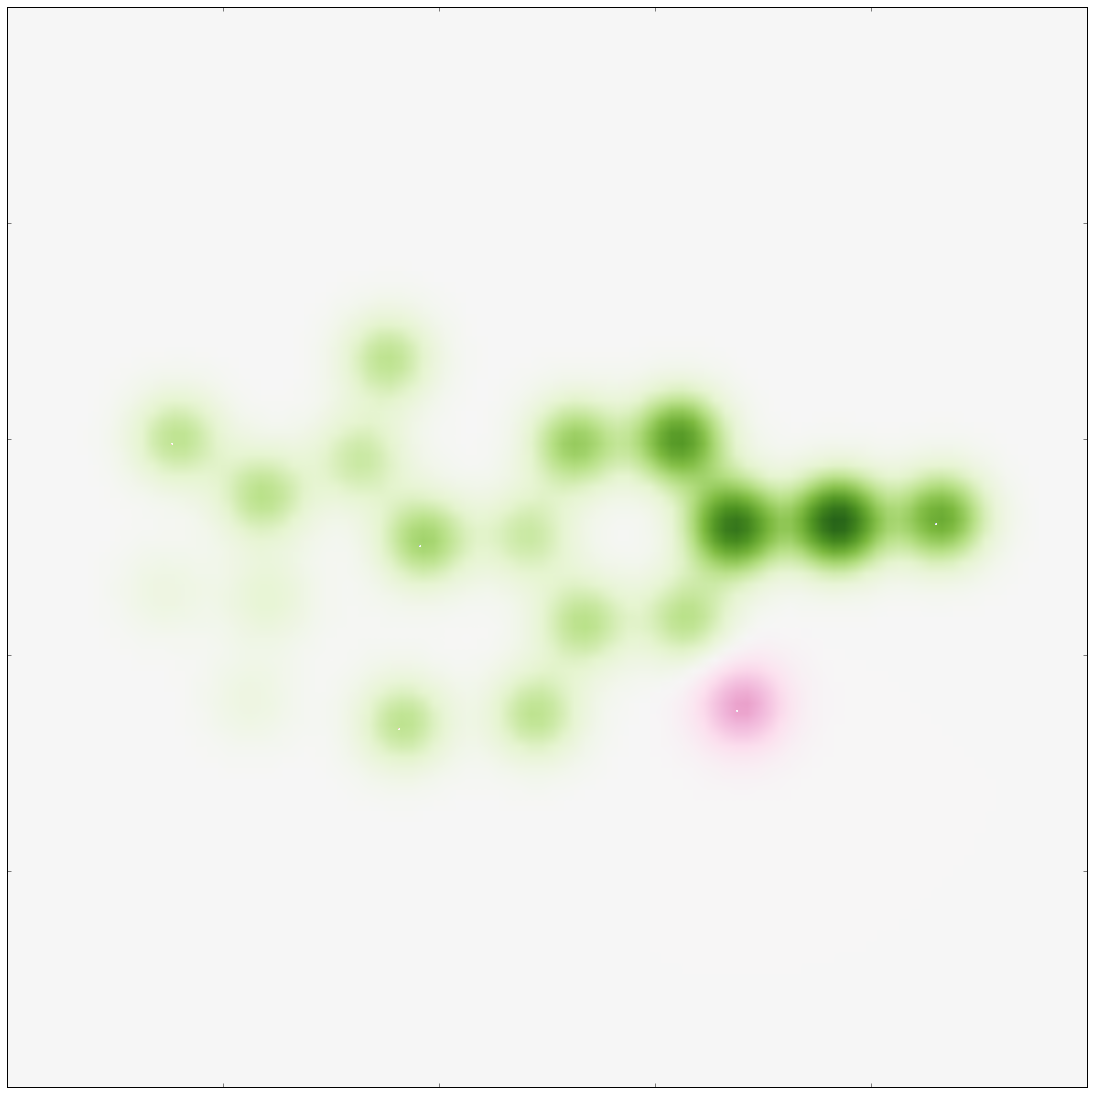

In [85]:
refmol = Chem.MolFromSmiles('CC1=C(C#N)C(S(=O)(N(CC)C(C)=O)=O)=CC=C1')
mol1 = Chem.MolFromSmiles('O=S(C1=CC=C(C#N)C=C1C)(N2C[C@@H](C)NCC2)=O')
mol1 = Chem.MolFromSmiles('O=C(N(C/C=C(C#N)/C)S1(=O)=O)C2=C1C=CC=C2')
mol1 = Chem.MolFromSmiles('O=S(C1=C(C#N)C(F)=CC=C1)(N(CC2)CC2=O)=O')
mol1 = Chem.MolFromSmiles('FC1=C(C#N)C=CC(N(C2C)C(C(C)(C)C2=O)=O)=C1C')

display(MolToImage(refmol))
display(MolToImage(mol1))
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import DrawingOptions
opts = DrawingOptions()
opts.bgColor = None
opts.atomLabelFontSize=0.000000000001
opts.bondLineWidth=0.000001
mol1 = Chem.MolFromSmiles(Chem.MolToSmiles(mol1, False))
display(MolToImage(mol1))
from rdkit import DataStructs
weights = SimilarityMaps.GetAtomicWeightsForFingerprint(refmol, mol1, lambda x,i: SimilarityMaps.GetMorganFingerprint(x, atomId=i, useFeatures=True), metric=DataStructs.TanimotoSimilarity)
fig = SimilarityMaps.GetSimilarityMapFromWeights(mol1, weights, size=(600,600), alpha=0, colors='k', options=opts)
display(fig)

took 0.059 seconds to get similarity


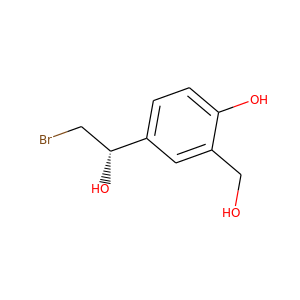

took 1.103 seconds to apply <= 100 templates


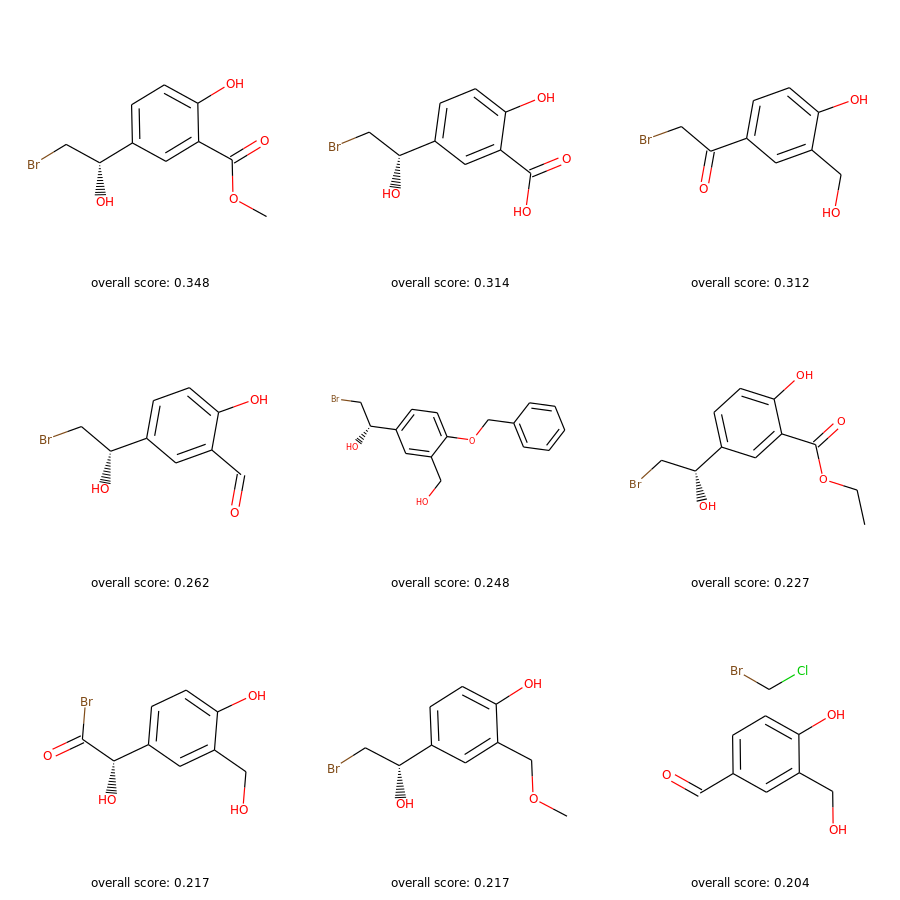

COC(=O)c1cc([C@H](O)CBr)ccc1O
O=C(O)c1cc([C@H](O)CBr)ccc1O
O=C(CBr)c1ccc(O)c(CO)c1
O=Cc1cc([C@H](O)CBr)ccc1O
OCc1cc([C@H](O)CBr)ccc1OCc1ccccc1
CCOC(=O)c1cc([C@H](O)CBr)ccc1O
O=C(Br)[C@@H](O)c1ccc(O)c(CO)c1
COCc1cc([C@H](O)CBr)ccc1O
ClCBr.O=Cc1ccc(O)c(CO)c1

Precedent sim 0.581395348837, rxn_smiles [CH2:1]=[CH:2][CH2:3][c:4]1[cH:5][c:6]([CH2:7][OH:8])[cH:9][cH:10][c:11]1[OH:12]>>[CH3:1][CH2:2][CH2:3][c:4]1[cH:5][c:6]([CH2:7][OH:8])[cH:9][cH:10][c:11]1[OH:12]

Precedent sim 0.568181818182, rxn_smiles CO[C:1](=[O:2])[c:3]1[cH:4][cH:5][c:6]([C:7]([F:8])([F:9])[F:10])[cH:11][c:12]1[OH:13]>>[CH2:1]([OH:2])[c:3]1[cH:4][cH:5][c:6]([C:7]([F:8])([F:9])[F:10])[cH:11][c:12]1[OH:13]
prec sim 0.612244897959 smiles COC(=O)c1cc([C@H](O)CBr)ccc1O

Precedent sim 0.558139534884, rxn_smiles [CH3:1][c:2]1[cH:3][c:4]([CH3:5])[cH:6][c:7]([C:8](=[O:9])[CH2:10][Br:11])[cH:12]1>>[CH3:1][c:2]1[cH:3][c:4]([CH3:5])[cH:6][c:7]([C@H:8]([OH:9])[CH2:10][Br:11])[cH:12]1
prec sim 0.558139534884 smiles O=C(CBr)c1ccc(O)c(

['COC(=O)c1cc([C@H](O)CBr)ccc1O',
 'O=C(O)c1cc([C@H](O)CBr)ccc1O',
 'O=C(CBr)c1ccc(O)c(CO)c1',
 'O=Cc1cc([C@H](O)CBr)ccc1O',
 'OCc1cc([C@H](O)CBr)ccc1OCc1ccccc1',
 'CCOC(=O)c1cc([C@H](O)CBr)ccc1O',
 'O=C(Br)[C@@H](O)c1ccc(O)c(CO)c1',
 'COCc1cc([C@H](O)CBr)ccc1O',
 'ClCBr.O=Cc1ccc(O)c(CO)c1',
 'OCc1cc([C@@H](CBr)OCc2ccccc2)ccc1O',
 'Oc1ccc([C@H](O)CBr)cc1COCc1ccccc1',
 'CC(=O)O[C@H](CBr)c1ccc(O)c(CO)c1',
 'COc1ccc([C@H](O)CBr)cc1CO',
 'O=Cc1ccc(O)c(CO)c1.[Mg+]CBr',
 'CO[C@H](CBr)c1ccc(O)c(CO)c1',
 'OCc1cc([C@@](O)(Br)CBr)ccc1O']

In [8]:
do_one('OCc1cc([C@H](O)CBr)ccc1O', debug=True)

took 2.753 seconds to get similarity


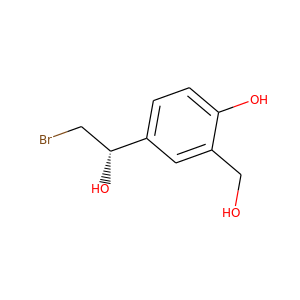

took 0.944 seconds to apply <= 100 templates


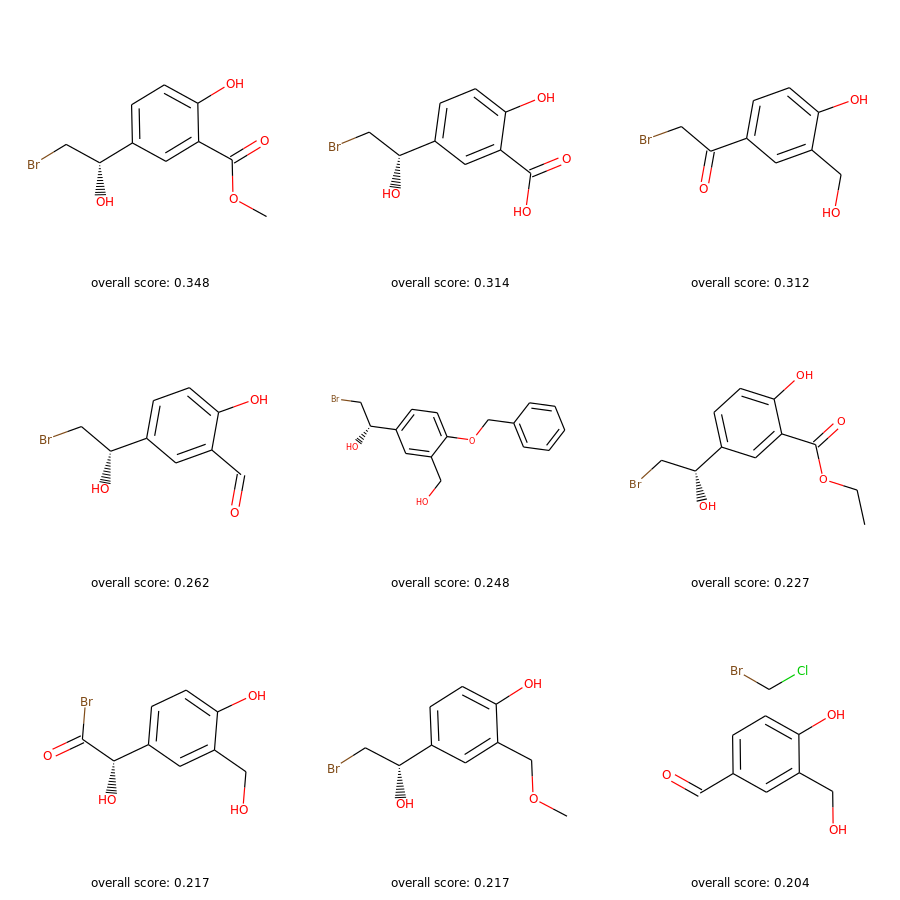

COC(=O)c1cc([C@H](O)CBr)ccc1O
O=C(O)c1cc([C@H](O)CBr)ccc1O
O=C(CBr)c1ccc(O)c(CO)c1
O=Cc1cc([C@H](O)CBr)ccc1O
OCc1cc([C@H](O)CBr)ccc1OCc1ccccc1
CCOC(=O)c1cc([C@H](O)CBr)ccc1O
O=C(Br)[C@@H](O)c1ccc(O)c(CO)c1
COCc1cc([C@H](O)CBr)ccc1O
ClCBr.O=Cc1ccc(O)c(CO)c1

Precedent sim 0.581395348837, rxn_smiles [CH2:1]=[CH:2][CH2:3][c:4]1[cH:5][c:6]([CH2:7][OH:8])[cH:9][cH:10][c:11]1[OH:12]>>[CH3:1][CH2:2][CH2:3][c:4]1[cH:5][c:6]([CH2:7][OH:8])[cH:9][cH:10][c:11]1[OH:12]

Precedent sim 0.568181818182, rxn_smiles CO[C:1](=[O:2])[c:3]1[cH:4][cH:5][c:6]([C:7]([F:8])([F:9])[F:10])[cH:11][c:12]1[OH:13]>>[CH2:1]([OH:2])[c:3]1[cH:4][cH:5][c:6]([C:7]([F:8])([F:9])[F:10])[cH:11][c:12]1[OH:13]
prec sim 0.612244897959 smiles COC(=O)c1cc([C@H](O)CBr)ccc1O

Precedent sim 0.558139534884, rxn_smiles [CH3:1][c:2]1[cH:3][c:4]([CH3:5])[cH:6][c:7]([C:8](=[O:9])[CH2:10][Br:11])[cH:12]1>>[CH3:1][c:2]1[cH:3][c:4]([CH3:5])[cH:6][c:7]([C@H:8]([OH:9])[CH2:10][Br:11])[cH:12]1
prec sim 0.558139534884 smiles O=C(CBr)c1ccc(O)c(

['COC(=O)c1cc([C@H](O)CBr)ccc1O',
 'O=C(O)c1cc([C@H](O)CBr)ccc1O',
 'O=C(CBr)c1ccc(O)c(CO)c1',
 'O=Cc1cc([C@H](O)CBr)ccc1O',
 'OCc1cc([C@H](O)CBr)ccc1OCc1ccccc1',
 'CCOC(=O)c1cc([C@H](O)CBr)ccc1O',
 'O=C(Br)[C@@H](O)c1ccc(O)c(CO)c1',
 'COCc1cc([C@H](O)CBr)ccc1O',
 'ClCBr.O=Cc1ccc(O)c(CO)c1',
 'OCc1cc([C@@H](CBr)OCc2ccccc2)ccc1O',
 'Oc1ccc([C@H](O)CBr)cc1COCc1ccccc1',
 'CC(=O)O[C@H](CBr)c1ccc(O)c(CO)c1',
 'COc1ccc([C@H](O)CBr)cc1CO',
 'O=Cc1ccc(O)c(CO)c1.[Mg+]CBr',
 'CO[C@H](CBr)c1ccc(O)c(CO)c1',
 'OCc1cc([C@@](O)(Br)CBr)ccc1O']

In [9]:
do_one('OCc1cc([C@H](O)CBr)ccc1O', debug=True)